To beat bookmakers, we used ML to predict matches as accurate as possible. Algorithms:
- Random Forest
- Decision tree with Ada boost
- Support Vector Machine
- Voting algorithm combining above-mentioned algorithms
- Neural Network

In [ ]:
import pandas as pd
import sklearn.model_selection
import sklearn.preprocessing
import joblib

# Load from disk
features = pd.read_csv("archive/features.csv", index_col=0)
df_atp_reduced = pd.read_csv("archive/df_atp_reduced.csv", index_col=0)

target = features["P1==Winner"]
data = features.drop(labels=["P1==Winner"], axis=1)

scaler = sklearn.preprocessing.StandardScaler()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index), target, test_size=0.05, shuffle=False, random_state=4362)

# Save the scaler on the disk
joblib.dump(value=scaler, filename="archive/scaler.pkl")

features.tail()

# Random Forest Classifier:

A grid search to find the optimum hyperparameters for random forest:

In [62]:
import sklearn.ensemble
import sklearn.model_selection
import joblib

# Create and train grid model on Random Forest
grid_rf = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.RandomForestClassifier(), param_grid={"max_depth" : range(5, 20), "random_state" : range(42, 52), "max_features": ["sqrt", "log2", None], "min_samples_split": range(20, 31)}, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_rf, filename="archive/grid_rf.pkl")

grid_rf.best_params_
# output: {"max_depth": 12, "max_features": "sqrt", "min_samples_split": 27, "random_state": 47}

{'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_split': 27,
 'random_state': 47}

In [63]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import joblib

# Create and fit the model with the optimum hyperparameters
model_rfc = sklearn.ensemble.RandomForestClassifier(max_depth=12, max_features="sqrt", min_samples_split=27, random_state=47, n_jobs=-1)
model_rfc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_rfc, filename="archive/model_rfc.pkl")

rfc_result = pd.DataFrame({"rfc_result": ~np.logical_xor(model_rfc.predict(X_test), y_test), "rfc_proba_P1_wins": model_rfc.predict_proba(X_test)[:, 1]}, index=y_test.index)

print(f"Random forest with the given features can predict correctly with the probability of {round(model_rfc.score(X_test, y_test)*100, 2)} %")

try:
    # Load profits_test from disk
    profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)
    profits_test[["rfc_result", "rfc_certainty", "rfc_profit_PS", "rfc_profit_B365"]] = pd.DataFrame({"rfc_result": 0 + rfc_result["rfc_result"], "rfc_certainty": 2*(rfc_result["rfc_proba_P1_wins"] - .5).abs(), "rfc_profit_PS": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "rfc_profit_B365": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
except:
    profits_test = pd.DataFrame({"rfc_result": 0 + rfc_result["rfc_result"], "rfc_certainty": 2*(rfc_result["rfc_proba_P1_wins"] - .5).abs(), "rfc_profit_PS": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "rfc_profit_B365": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Random forest with the given features can predict correctly with the probability of 65.0 %


# Decision Tree Classifier with Ada Boost:

A grid search to find the optimum hyperparameters for Ada boost (on decision tree):

In [39]:
import sklearn.model_selection
import sklearn.ensemble
import numpy as np
import joblib

# Create and train grid model on Ada boost (on decision tree)
grid_dtc_abc = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.AdaBoostClassifier(), param_grid={"estimator": [sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth=3), sklearn.tree.DecisionTreeClassifier(criterion="gini", max_depth=3)], "learning_rate": np.power(10.0, np.arange(-3, 0, .5)), "n_estimators": range(100, 1001, 100), "algorithm": ["SAMME"], "random_state": [26645]}, n_jobs=-1)
grid_dtc_abc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_dtc_abc, filename="archive/grid_dtc_abc.pkl")

grid_dtc_abc.best_params_
# output: {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.03162277660168379, 'n_estimators': 600, 'random_state': 26645}

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import sklearn.tree
import sklearn.ensemble
import joblib

# Create and fit the model with the optimum hyperparameters
model_dtc = sklearn.tree.DecisionTreeClassifier(max_depth=3)
model_dtc_abc = sklearn.ensemble.AdaBoostClassifier(estimator=model_dtc, learning_rate=3.162277660168379e-2, n_estimators=600, algorithm="SAMME", random_state=26645)
model_dtc_abc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_dtc_abc, filename="archive/model_dtc_abc.pkl")

dtc_abc_result = pd.DataFrame({"dtc_abc_result": ~np.logical_xor(model_dtc_abc.predict(X_test), y_test), "dtc_abc_proba_P1_wins": model_dtc_abc.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of {round(model_dtc_abc.score(X_test, y_test)*100, 2)} %")

try:
    # Load profits_test from disk
    profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)
    profits_test[["dtc_abc_result", "dtc_abc_certainty", "dtc_abc_profit_PS", "dtc_abc_profit_B365"]] = pd.DataFrame({"dtc_abc_result": 0 + dtc_abc_result["dtc_abc_result"], "dtc_abc_certainty": 2*(dtc_abc_result["dtc_abc_proba_P1_wins"] - .5).abs(), "dtc_abc_profit_PS": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "dtc_abc_profit_B365": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
except:
    profits_test = pd.DataFrame({"dtc_abc_result": 0 + dtc_abc_result["dtc_abc_result"], "dtc_abc_certainty": 2*(dtc_abc_result["dtc_abc_proba_P1_wins"] - .5).abs(), "dtc_abc_profit_PS": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "dtc_abc_profit_B365": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)


# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of 70.69 %


# Support Vector Classifier:

A grid search to find the optimum hyperparameters for svm:

In [ ]:
import sklearn.svm
import sklearn.model_selection
import joblib

# Create and train grid model on svm
grid_svm = sklearn.model_selection.GridSearchCV(estimator=sklearn.svm.SVC(), param_grid={"kernel" : ["rbf", "linear", "poly", "sigmoid"], "C" : [.1, 1.0, 10.0, 50.0], "random_state": [9274]}, n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_svm, filename="archive/grid_svm.pkl")

grid_svm.best_params_
# output: {"C": 1.0, "kernel": "rbf", "random_state": 9274}

{'C': 1.0, 'kernel': 'rbf', 'random_state': 9274}

In [ ]:
import pandas as pd
import numpy as np
import sklearn.svm
import joblib

# Create and fit the model with the optimum hyperparameters
model_svm = sklearn.svm.SVC(kernel="rbf", C=1.0, probability=True, random_state=9274)
model_svm.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_svm, filename="archive/model_svm.pkl")

svm_result = pd.DataFrame({"svm_result": ~np.logical_xor(model_svm.predict(X_test), y_test), "svm_proba_P1_wins": model_svm.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"SVM with the given features can predict correctly with the probability of {round(model_svm.score(X_test, y_test)*100, 2)} %")

try:
    # Load profits_test from disk
    profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)
    profits_test[["svm_result", "svm_certainty", "svm_profit_PS", "svm_profit_B365"]] = pd.DataFrame({"svm_result": 0 + svm_result["svm_result"], "svm_certainty": 2*(svm_result["svm_proba_P1_wins"] - .5).abs(), "svm_profit_PS": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "svm_profit_B365": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
except:
    profits_test = pd.DataFrame({"svm_result": 0 + svm_result["svm_result"], "svm_certainty": 2*(svm_result["svm_proba_P1_wins"] - .5).abs(), "svm_profit_PS": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "svm_profit_B365": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

SVM with the given features can predict correctly with the probability of 69.89 %


In [ ]:
import sklearn.ensemble
import joblib
import pandas as pd

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

accuracies = profits_test[["rfc_result", "dtc_abc_result", "svm_result"]].mean(axis=0).to_numpy()

# Create and fit the voting model
model_vc = sklearn.ensemble.VotingClassifier(estimators=[("rfc", model_rfc), ("dtc_abc", model_dtc_abc), ("svc", model_svm)], weights=accuracies, voting="soft", n_jobs=-1)
model_vc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_vc, filename="archive/model_vc.pkl")

vc_result = pd.DataFrame({"vc_result": ~np.logical_xor(model_vc.predict(X_test), y_test), "vc_proba_P1_wins": model_vc.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"Voting classifier with the given features can predict correctly with the probability of {round(model_vc.score(X_test, y_test)*100, 2)} %")

try:
    # Load profits_test from disk
    profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)
    profits_test[["vc_result", "vc_certainty", "vc_profit_PS", "vc_profit_B365"]] = pd.DataFrame({"vc_result": 0 + vc_result["vc_result"], "vc_certainty": 2*(vc_result["vc_proba_P1_wins"] - .5).abs(), "vc_profit_PS": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "vc_profit_B365": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
except:
    profits_test = pd.DataFrame({"vc_result": 0 + vc_result["vc_result"], "vc_certainty": 2*(vc_result["vc_proba_P1_wins"] - .5).abs(), "vc_profit_PS": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "vc_profit_B365": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Voting classifier with the given features can predict correctly with the probability of 71.43 %


# Neural Network Classifier:

In [ ]:
import tensorflow as tf

# Define the model
model_nn = tf.keras.models.Sequential()

# Add layers to the model
model_nn.add(tf.keras.layers.Dense(40, input_dim=29, activation='relu'))    # Input layer with 29 features
# model_nn.add(tf.keras.layers.Dropout(rate=.2))                              # Dropout layer
model_nn.add(tf.keras.layers.Dense(25, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(10, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(5, activation='sigmoid'))                # Hidden layer
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))                # Output layer with sigmoid activation for binary classification

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
# model_nn.summary()

# Fit the model
history = model_nn.fit(X_train, y_train + 0.0, epochs=60, batch_size=32, validation_data=(X_test, y_test))

# Save the model on disk
model_nn.save("archive/model_nn.keras")

nn_result = pd.DataFrame({"nn_result": ~np.logical_xor(model_nn.predict(X_test)[:, 0]>.5, y_test), "nn_proba_P1_wins": model_nn.predict(X_test)[:, 0]}, index=y_test.index)
print(f"Neural network algorithm with the given features can predict correctly with the probability of {round(model_nn.evaluate(X_test, y_test)[1]*100, 2)} %")

try:
    # Load profits_test from disk
    profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)
    profits_test[["nn_result", "nn_certainty", "nn_profit_PS", "nn_profit_B365"]] = pd.DataFrame({"nn_result": 0 + nn_result["nn_result"], "nn_certainty": 2*(nn_result["nn_proba_P1_wins"] - .5).abs(), "nn_profit_PS": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "nn_profit_B365": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)
except:
    profits_test = pd.DataFrame({"nn_result": 0 + nn_result["nn_result"], "nn_certainty": 2*(nn_result["nn_proba_P1_wins"] - .5).abs(), "nn_profit_PS": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "nn_profit_B365": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)


# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Epoch 1/60
10/10 [==============================] - 2s 37ms/step - loss: 0.7094 - accuracy: 0.4992 - val_loss: 0.7053 - val_accuracy: 0.4973
Epoch 2/60
10/10 [==============================] - 0s 11ms/step - loss: 0.7017 - accuracy: 0.4992 - val_loss: 0.6987 - val_accuracy: 0.4973
Epoch 3/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6962 - accuracy: 0.4992 - val_loss: 0.6941 - val_accuracy: 0.4973
Epoch 4/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.4992 - val_loss: 0.6908 - val_accuracy: 0.4973
Epoch 5/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6894 - accuracy: 0.5030 - val_loss: 0.6883 - val_accuracy: 0.5292
Epoch 6/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.5866 - val_loss: 0.6857 - val_accuracy: 0.6320
Epoch 7/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6842 - accuracy: 0.6471 - val_loss: 0.6829 - val_accuracy: 0.6394
Epoch 8/60
10

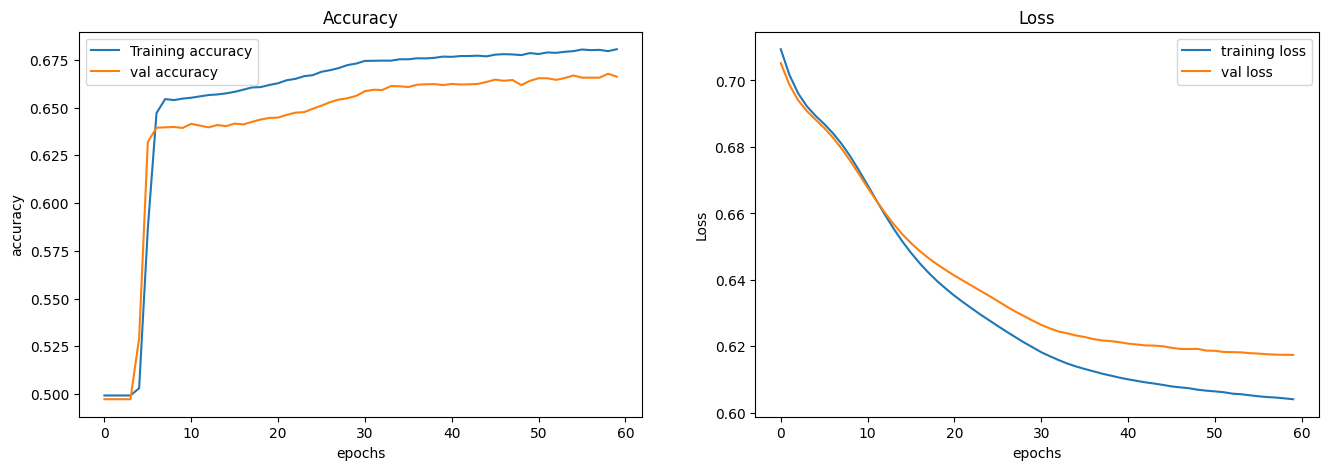

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()